# Table of Contents
## I. Setting Up Environment
1. Setting up Spark Session and Loading Data

## II. Preprocessing
2. Non-empty reviews

3. Selecting 4 styles of beer to classify

4. Cleaning numeric fields

## III. Exploratory Analysis and Vizualizations
5. Summary statistics for each style of beer and for entire dataset

## IV. Modeling
6. Creating Pipelines and Cross Validators

7. Baseline Model for Entire Dataset (Unbalanced Classes)

    7.1 CV TF-IDF Parameters
    
8. Baseline Model for Sampled Dataset (Balanced Classes)

    8.1 CV TF-IDF Parameters
    
    8.2 Choose Best parameters for Baseline ML Models
    
10. Baseline for Machine Learning Models with Balanced data and TF-IDF Parameters

    10.1 Naive Bayes Base Model (Should be same as 8.1)
    
    10.2 Logistic Regression Base Model
    
    10.3 Random Forest Base Model
    
11. CV ML Models

    11.1 Best Naive Bayes Parameters
    
    11.2 Best Logistic Regression Parameters
    
    11.3 Best Random Forest Parameters

## V. Next Steps (might be able to finish)

12. Stemming or Lemmatization

13. N-Grams

## VI. Next Steps (probably won't be able to finish)
14. Deep Learning

15. Recommendation System

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# I . Setting Up Environment

## 1. Setting Up Spark Session and Loading Data

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.ml.feature import *
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import NaiveBayes, LogisticRegression, RandomForestClassifier, MultilayerPerceptronClassifier
from nltk.stem.snowball import SnowballStemmer
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import string
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
spark = SparkSession \
    .builder \
    .master("local") \
    .appName("Project Notebook") \
    .config("spark.executor.memory", '10g') \
    .config("spark.executor.cores", '5') \
    .config('spark.cores.max', '5') \
    .config('spark.driver.memory', '10g') \
    .getOrCreate()

sc = spark.sparkContext

In [3]:
beers = spark.read.format('csv'). \
    option("header", "true"). \
    option("inferSchema", "true"). \
    load("/home/aaron/BigData135/datasets/beers.csv")

In [4]:
reviews = spark.read.format('csv'). \
    option("header", "true"). \
    option("inferSchema", "true"). \
    load("/home/aaron/BigData135/datasets/reviews.csv")

In [45]:
beers.printSchema()

root
 |-- id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- brewery_id: string (nullable = true)
 |-- state: string (nullable = true)
 |-- country: string (nullable = true)
 |-- style: string (nullable = true)
 |-- availability: string (nullable = true)
 |-- abv: string (nullable = true)
 |-- notes: string (nullable = true)
 |-- retired: string (nullable = true)



In [46]:
reviews.printSchema()

root
 |-- beer_id: integer (nullable = true)
 |-- username: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- text: string (nullable = true)
 |-- look: string (nullable = true)
 |-- smell: string (nullable = true)
 |-- taste: string (nullable = true)
 |-- feel: string (nullable = true)
 |-- overall: string (nullable = true)
 |-- score: string (nullable = true)



In [47]:
beers.show(5)

+------+--------------------+----------+-----+-------+--------------------+------------+----+--------------------+-------+
|    id|                name|brewery_id|state|country|               style|availability| abv|               notes|retired|
+------+--------------------+----------+-----+-------+--------------------+------------+----+--------------------+-------+
|202522|      Olde Cogitator|      2199|   CA|     US|English Oatmeal S...|    Rotating| 7.3|No notes at this ...|      f|
| 82352|Konrads Stout Rus...|     18604| null|     NO|Russian Imperial ...|    Rotating|10.4|No notes at this ...|      f|
|214879|      Scottish Right|     44306|   IN|     US|        Scottish Ale|  Year-round|   4|No notes at this ...|      t|
|320009|MegaMeow Imperial...|      4378|   WA|     US|American Imperial...|      Winter| 8.7|Every time this year|      f|
|246438|     Peaches-N-Cream|     44617|   PA|     US|  American Cream Ale|    Rotating| 5.1|No notes at this ...|      f|
+------+--------

In [48]:
beers.count()

358873

In [49]:
#How many beers in each style
beers.groupBy('style').count().sort('count', ascending = False).show(20)

+--------------------+-----+
|               style|count|
+--------------------+-----+
|        American IPA|44719|
|American Pale Ale...|22159|
|American Imperial...|18336|
|      Belgian Saison|18166|
|   American Wild Ale|12972|
|American Imperial...|11180|
|     American Porter|10168|
|American Amber / ...| 9748|
|      American Stout| 9103|
|Fruit and Field Beer| 7729|
| American Blonde Ale| 7089|
|  American Brown Ale| 7008|
|   German Hefeweizen| 6019|
|     Belgian Witbier| 5613|
|American Pale Whe...| 5266|
|     Berliner Weisse| 5036|
|      German Pilsner| 4748|
|    Belgian Pale Ale| 4523|
|Russian Imperial ...| 4426|
|English Sweet / M...| 4192|
+--------------------+-----+
only showing top 20 rows



In [50]:
reviews.show(5) 

+-------+---------------+-------------------+--------------------+--------------------+--------------------+------+--------------------+-----------------+------------------+
|beer_id|       username|               date|                text|                look|               smell| taste|                feel|          overall|             score|
+-------+---------------+-------------------+--------------------+--------------------+--------------------+------+--------------------+-----------------+------------------+
| 271781|   bluejacket74|2017-03-17 00:00:00|   750 ml bottle,...|                   4|                   4|     4|                4.25|                4|              4.03|
| 125646|        _dirty_|2017-12-21 00:00:00|                    |                 4.5|                 4.5|   4.5|                 4.5|              4.5|               4.5|
| 125646|        CJDUBYA|2017-12-21 00:00:00|                    |                4.75|                4.75|  4.75|               

In [51]:
reviews.count()

9073128

# II. Preprocessing

## 2. Non Empty Reviews, Remove Punctuation and Strip Whitespace

In [52]:
#Count Non-empty reviews
(reviews.filter(reviews['text'] != '\xa0\xa0')).count()

2987993

In [5]:
non_empty_reviews = reviews.filter(reviews['text'] != '\xa0\xa0') #non-empty review df

In [8]:
non_empty_reviews = non_empty_reviews.withColumn('text', F.regexp_replace('text', "\\.|\xa0|!|,|:", ""))\
                                    .withColumn('text', F.trim(F.col('text')))#remove punctuation, trim extra whitespace

In [53]:
non_empty_reviews.show(10)

+-------+---------------+-------------------+--------------------+--------------------+--------------------+------+--------------------+-----------------+------------------+
|beer_id|       username|               date|                text|                look|               smell| taste|                feel|          overall|             score|
+-------+---------------+-------------------+--------------------+--------------------+--------------------+------+--------------------+-----------------+------------------+
| 271781|   bluejacket74|2017-03-17 00:00:00|750 ml bottle 201...|                   4|                   4|     4|                4.25|                4|              4.03|
| 125646|GratefulBeerGuy|2017-12-20 00:00:00|" 0% 16 oz can Fu...| bloomin' like a ...| totally unfilter...| thick| all-white clumps...| mellon and mango| grainy earthiness|
| 125646|       LukeGude|2017-12-20 00:00:00|Classic TH NEIPA ...|                4.25|                 4.5|  4.25|               

In [62]:
#Counts how many beers have non-empty reviews
non_empty_reviews.agg(F.countDistinct("beer_id")).show()#how many distinct beers are reviewed

+-----------------------+
|count(DISTINCT beer_id)|
+-----------------------+
|                 210311|
+-----------------------+



## Creating Main Dataframe

In [9]:
beerStyles = beers.select("id","style")

In [64]:
beerStyles.show(5)

+------+--------------------+
|    id|               style|
+------+--------------------+
|202522|English Oatmeal S...|
| 82352|Russian Imperial ...|
|214879|        Scottish Ale|
|320009|American Imperial...|
|246438|  American Cream Ale|
+------+--------------------+
only showing top 5 rows



In [11]:
beerStyles = beerStyles.withColumnRenamed('id', 'beer_id')

In [12]:
mainDF = non_empty_reviews.join(beerStyles, "beer_id")#join adds the style of beer to the non empty review df

In [67]:
mainDF.select('beer_id').distinct().count()#just checking join worked correctly

210294

In [13]:
mainDF.select('style').distinct().count()#how many distinct style of beer

116

In [68]:
#Counts how many reviews for each style of beer
mainDF.groupBy('style').count().sort('count', ascending = False).show(truncate = False)

+------------------------+------+
|style                   |count |
+------------------------+------+
|American IPA            |301774|
|American Imperial IPA   |212697|
|American Imperial Stout |150160|
|American Pale Ale (APA) |126489|
|Belgian Saison          |91000 |
|Russian Imperial Stout  |86117 |
|American Porter         |71189 |
|American Wild Ale       |63393 |
|American Amber / Red Ale|62818 |
|Fruit and Field Beer    |58342 |
|Belgian Strong Dark Ale |53097 |
|Belgian Witbier         |46545 |
|Belgian Strong Pale Ale |45732 |
|Belgian Tripel          |45686 |
|American Brown Ale      |44774 |
|American Strong Ale     |43575 |
|German Hefeweizen       |42930 |
|American Stout          |41879 |
|American Barleywine     |40873 |
|American Adjunct Lager  |39404 |
+------------------------+------+
only showing top 20 rows



In [116]:
#Counts how many unique beers of that style is reviewed
mainDF.select('beer_id', 'style').distinct().groupBy('style').count().sort('count', ascending = False).show(truncate = False)

+------------------------+-----+
|style                   |count|
+------------------------+-----+
|American IPA            |24380|
|American Pale Ale (APA) |12216|
|American Imperial IPA   |11517|
|Belgian Saison          |9744 |
|American Wild Ale       |7390 |
|American Imperial Stout |7016 |
|American Porter         |5889 |
|American Amber / Red Ale|5573 |
|American Stout          |4782 |
|Fruit and Field Beer    |4471 |
|American Brown Ale      |3682 |
|German Hefeweizen       |3395 |
|American Blonde Ale     |3329 |
|Belgian Witbier         |3036 |
|German Pilsner          |3024 |
|Russian Imperial Stout  |2946 |
|American Pale Wheat Ale |2793 |
|Belgian Pale Ale        |2630 |
|Berliner Weisse         |2586 |
|English Bitter          |2545 |
+------------------------+-----+
only showing top 20 rows



### As we can see American Imperial Stout has the 3rd most reviews but only 6th most unique beers. This means that there are a few beers that are American Imperial Stouts with many reviews. We will choose Belgian Saison for classification because it has the 5th most reviews and the 4th most unique beers that have been reviewed

## 3. Selecting Targets, Top 4 most reviewed styles (with most unique beers)

In [14]:
styleTargets = ['American IPA', 'American Pale Ale (APA)', 'American Imperial IPA', 'Belgian Saison']# the styles we wish to classify

In [118]:
mainDF.filter(mainDF['style'].isin(styleTargets)).count()#size of our main Dataset

731960

In [15]:
mainStyles = mainDF.filter(mainDF['style'].isin(styleTargets))

In [140]:
mainStyles.groupBy('style').count().sort('count', ascending = False).show(truncate = False)#counts how many reviews per style
#note the class imbalance

+-----------------------+------+
|style                  |count |
+-----------------------+------+
|American IPA           |301774|
|American Imperial IPA  |212697|
|American Pale Ale (APA)|126489|
|Belgian Saison         |91000 |
+-----------------------+------+



In [141]:
mainStyles.select('beer_id', 'style').distinct().groupBy('style').count().sort('count', ascending = False).show(truncate = False)#counts how many unique beers were reviewed for each style
#note the class imbalance

+-----------------------+-----+
|style                  |count|
+-----------------------+-----+
|American IPA           |24380|
|American Pale Ale (APA)|12216|
|American Imperial IPA  |11517|
|Belgian Saison         |9744 |
+-----------------------+-----+



## 4. Clean Numeric Features

In [120]:
mainStyles.printSchema()#check schema

root
 |-- beer_id: integer (nullable = true)
 |-- username: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- text: string (nullable = true)
 |-- look: string (nullable = true)
 |-- smell: string (nullable = true)
 |-- taste: string (nullable = true)
 |-- feel: string (nullable = true)
 |-- overall: string (nullable = true)
 |-- score: string (nullable = true)
 |-- style: string (nullable = true)



In [16]:
#Removes rows with NA's and Text in Numerical Columns
model_df = mainStyles.filter(F.col("look").cast("int").isNotNull() == True)\
            .filter(F.col("smell").cast("int").isNotNull() == True)\
            .filter(F.col("taste").cast("int").isNotNull() == True)\
            .filter(F.col("feel").cast("int").isNotNull() == True)\
            .filter(F.col("overall").cast("int").isNotNull() == True)\
            .filter(F.col("score").cast("int").isNotNull() == True)

In [17]:
#Cast Numerical columns as floats now that strings and na's are removed
model_df = model_df.withColumn('look', model_df['look'].cast("float"))\
        .withColumn('smell', model_df['smell'].cast("float"))\
        .withColumn('taste', model_df['taste'].cast("float"))\
        .withColumn('feel', model_df['feel'].cast("float"))\
        .withColumn('overall', model_df['overall'].cast("float"))\
        .withColumn('score', model_df['score'].cast("float"))\

In [18]:
model_df = model_df.withColumn('beer_id', model_df['beer_id'].cast("string"))#this couldve been added to above cell but wanted to keep separate

In [19]:
model_df = model_df.drop("username", "date")#dont need these columns

In [124]:
# Last check for NA's
model_df.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in model_df.columns]).show()

+-------+----+----+-----+-----+----+-------+-----+-----+
|beer_id|text|look|smell|taste|feel|overall|score|style|
+-------+----+----+-----+-----+----+-------+-----+-----+
|      0|   0|   0|    0|    0|   0|      0|    0|    0|
+-------+----+----+-----+-----+----+-------+-----+-----+



In [20]:
model_df.printSchema()#make sure each column has correct datatype 

root
 |-- beer_id: string (nullable = true)
 |-- text: string (nullable = true)
 |-- look: float (nullable = true)
 |-- smell: float (nullable = true)
 |-- taste: float (nullable = true)
 |-- feel: float (nullable = true)
 |-- overall: float (nullable = true)
 |-- score: float (nullable = true)
 |-- style: string (nullable = true)



# III. Exploratory Analysis and Vizualization

## 5. Comparison of Means for Each Style and Summary Statistics for Entire Data

In [127]:
model_df.describe().show() #summary statistics for each column

+-------+-----------------+--------------------+------------------+------------------+------------------+------------------+------------------+-----------------+--------------+
|summary|          beer_id|                text|              look|             smell|             taste|              feel|           overall|            score|         style|
+-------+-----------------+--------------------+------------------+------------------+------------------+------------------+------------------+-----------------+--------------+
|  count|           641356|              641356|            641356|            641356|            641356|            641356|            641356|           641356|        641356|
|   mean|86016.15441190229|            145855.5| 4.003611878582253|3.9516130666899505|3.9633885080984665| 3.931568037096402|3.9674755517996245|3.961756469417888|          null|
| stddev|86104.03033777044|   995375.9829575884|0.4889811619131977|0.5641361351138886|0.5939057486341173|0.54288064

In [126]:
model_df.groupBy('style')\#checks the mean of each numeric feature for every style, we can see there are slight differences: American Imperial IPA gets highest scores, APA gets lowest
        .agg(F.mean('look'), F.mean('smell'), F.mean('taste'), F.mean('feel'), F.mean('overall'),   
            F.mean('score')).show(truncate = True)

+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|               style|         avg(look)|        avg(smell)|        avg(taste)|         avg(feel)|      avg(overall)|        avg(score)|
+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|        American IPA| 3.986425988960963|3.9190130602160207|3.9318579356773973|3.9012531309383935|3.9446924219012685| 3.932736264468442|
|American Imperial...| 4.107345298701574|4.0981487760042805|4.1012994856092435| 4.058349711549159|4.0595800643120885| 4.089419074101148|
|American Pale Ale...|3.8744497214357474|3.7821011051237554|3.8132181021097815|3.7911087770572656|3.8725111882363685|3.8200986432859327|
|      Belgian Saison|3.9922546618708705|3.9455913114461367|3.9475109053340476|3.9248201576490396| 3.955256243463177|3.9501903062389685|
+--------------------+------------------+

## 6. Visualizations

In [15]:
vizData = model_df.toPandas() #toPandas for visualizations

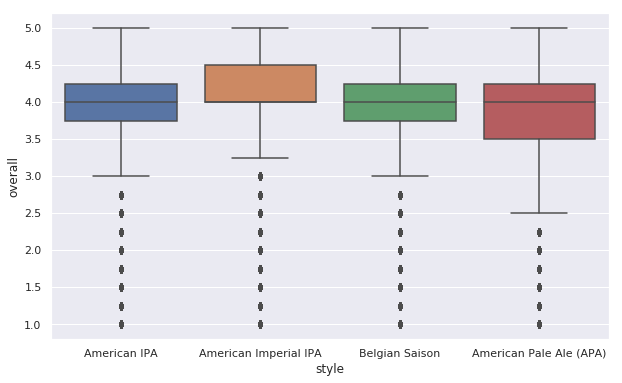

In [16]:
sns.set(rc={'figure.figsize':(10,6)})
sns.boxplot(x = 'style', y = "overall", data = vizData) #Box Plot for numeric feature "Overall"
#We only used one numeric feature for box plot since all of the other numeric features look like this

In [17]:
def show_wordcloud(data, title = None): #function to show word cloud
    wordcloud = WordCloud(
        background_color='white',
        max_words=200,
        max_font_size=40,
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

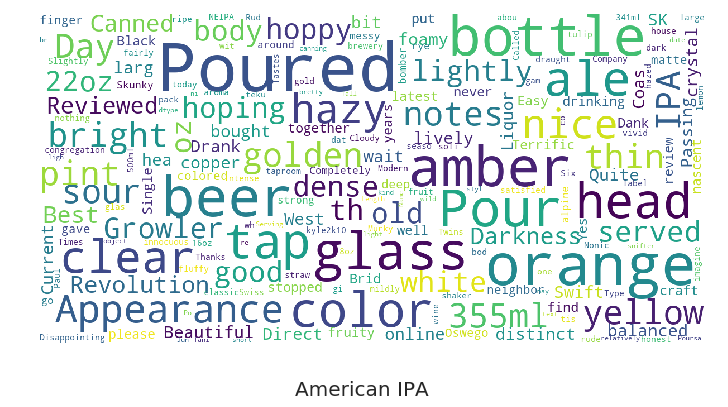

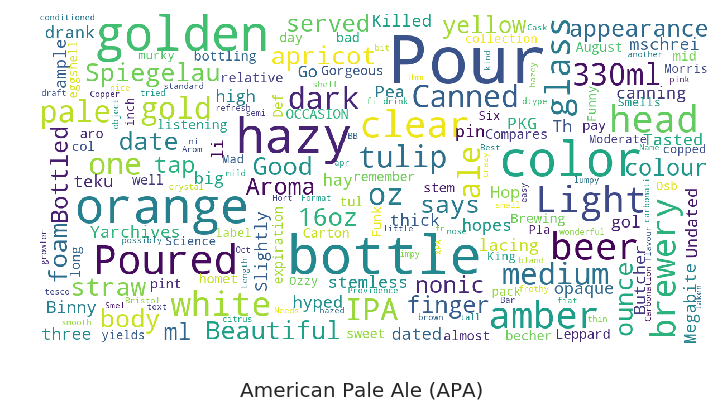

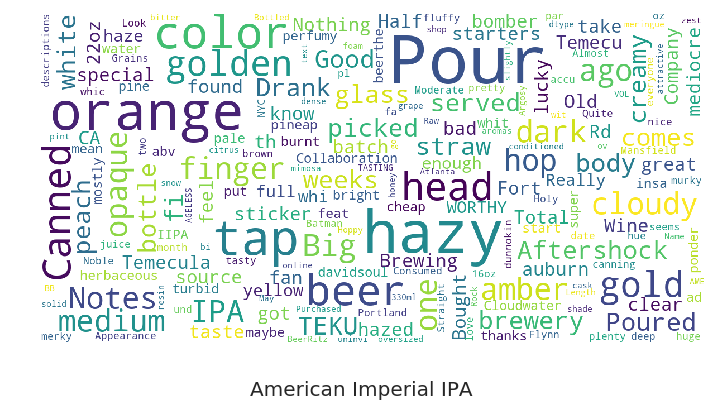

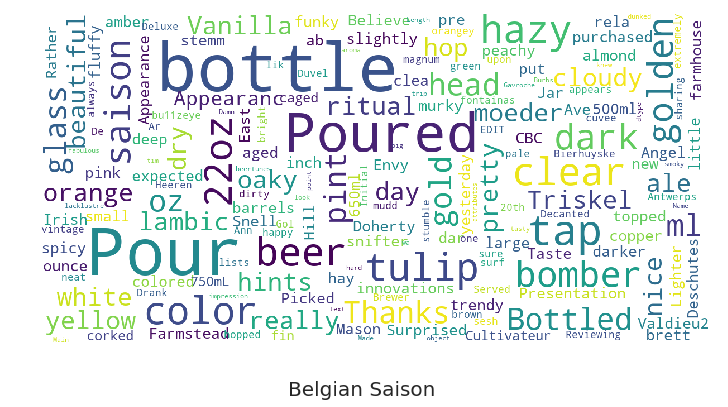

In [18]:
for style in styleTargets: #print wordcloud for each style
    show_wordcloud(vizData[vizData['style'] == style]['text'], title = str(style))

### The box plots for each of the numeric features resemble the one we should so we chose to include only 1 instead of 6
### The word cloud shows good differences for each style and also gives us some ideas such as stemming or including more custom stopwords that will obviously appear in all reviews such as "pour"

# IV. Modeling

## 7. Setting Up Pipelines 

### Note: HashingTF and IDF are updated with best parameters from parts 8 and 9 below. During the initial running of part 7 (before cross validation or undersampling) we used default parameters

Note: The Random Forest ParamGrid and Cross Validator have been removed for reasons that can be found later

In [14]:
tokenizer = Tokenizer(inputCol = "text", outputCol = "words")#tokenize words
stopRem = StopWordsRemover(inputCol = 'words', outputCol = 'filtered')#remove stopwords

In [15]:
text_pipe1 = Pipeline(stages = [tokenizer, stopRem])#first pipeline

In [16]:
token_text = text_pipe1.fit(model_df)

In [17]:
token_text_df = token_text.transform(model_df)

In [107]:
stemmer = SnowballStemmer(language='english')  #no built in stemmer for pyspark so can not add to pipeline, this is why text_pipe1 was necessary
stemmer_udf = F.udf(lambda tokens: [stemmer.stem(token) for token in tokens], ArrayType(StringType()))
df_stemmed = token_text_df.withColumn("words_stemmed", stemmer_udf("filtered")).select('look', 'smell', 'taste', 'feel', 'overall', 'score', 'words_stemmed', 'style')#df after words are stemmed

In [46]:
hashingTF = HashingTF(inputCol = "words_stemmed", outputCol = "rawFeatures", numFeatures = 10000)#hashing term frequency
idf = IDF(inputCol = "rawFeatures", outputCol = "features", minDocFreq = 1000)#computes idf weights
stringIdx = StringIndexer(inputCol = 'style', outputCol = 'label')#changes styles to labels for modeling

In [47]:
#metrics, self explanatory
acc = MulticlassClassificationEvaluator(predictionCol = "prediction", metricName = 'accuracy')
f1 = MulticlassClassificationEvaluator(predictionCol = "prediction", metricName = 'f1')#weighted f1 score (since recall and precision are weighted themselves)
rec = MulticlassClassificationEvaluator(predictionCol = "prediction", metricName = 'weightedRecall')
prec = MulticlassClassificationEvaluator(predictionCol = "prediction", metricName = 'weightedPrecision')

In [132]:
#function to print the metrics
def printMetrics(pred):
    print('Accuracy: ', acc.evaluate(pred))
    print('Weighted F1: ', f1.evaluate(pred))
    print('Weighted Recall: ', rec.evaluate(pred))
    print('Weighted Precision: ', prec.evaluate(pred))

In [48]:
nb = NaiveBayes()
pipelineNB = Pipeline(stages=[hashingTF, idf, stringIdx, nb])#naive bayes pipeline

In [49]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label')
pipelineLogReg = Pipeline(stages=[hashingTF, idf, stringIdx, lr])#logistic regression pipeline

In [50]:
rf = RandomForestClassifier(labelCol = "label", featuresCol = "features", numTrees = 20, maxDepth = 10, maxBins = 32)
pipelineRF = Pipeline(stages = [hashingTF, idf, stringIdx, rf])#random forest pipeline

In [52]:
#parameter grid for TF-IDF
paramGridTFIDF = ParamGridBuilder()\
    .addGrid(hashingTF.numFeatures, [1000, 10000, 50000, 100000])\
    .addGrid(idf.minDocFreq, [100, 1000, 10000])\
    .build()

In [53]:
#param grid for Naive Bayes
paramGridNB = ParamGridBuilder()\
    .addGrid(nb.smoothing, [0.001, 0.01, 0.1, 0.5, 1, 1.5, 1.75])\
    .build()

In [54]:
#Param grid for Logistic Regression
paramGridLogReg = ParamGridBuilder()\
    .addGrid(lr.maxIter, [10, 50, 100])\
    .addGrid(lr.regParam, np.linspace(0,1,5))\
    .addGrid(lr.elasticNetParam, np.linspace(0,1,5))\
    .build()

In [55]:
#5-fold cv to find best TF-IDF param
cvTFIDF = CrossValidator(estimator = pipelineNB,
                              estimatorParamMaps = paramGridTFIDF,
                              evaluator = acc,
                              numFolds = 5)

In [56]:
#5-fold cv to find best Naive Bayes param
cvNB = CrossValidator(estimator = pipelineNB,
                         estimatorParamMaps = paramGridNB,
                         evaluator = acc,
                         numFolds = 5)

In [57]:
#5-fold cv to find best logistic regression param
cvLogReg = CrossValidator(estimator = pipelineLogReg,
                         estimatorParamMaps = paramGridLogReg,
                         evaluator = acc,
                         numFolds = 5)

## Baseline Model
- Unbalanced
- No subset/sample of data
- No N-Grams
- NO TF-IDF parameters
- Use default Naive Bayes

In [108]:
data1 = df_stemmed

In [38]:
data1.count() #unbalanced

641356

In [51]:
data1.groupBy('style').count().sort('count', ascending = False).show() #just sanity check

+--------------------+------+
|               style| count|
+--------------------+------+
|        American IPA|264697|
|American Imperial...|188767|
|American Pale Ale...|109490|
|      Belgian Saison| 78402|
+--------------------+------+



In [32]:
trainDat, testDat = data1.randomSplit([0.8, 0.2], seed = 69) #split train and test

In [33]:
tfidfModBase = pipelineNB.fit(trainDat) #baseline train

In [34]:
predTfidfBase = tfidfModBase.transform(testDat)#baseline test

In [35]:
printMetrics(predTfidfBase) #results with default TF-IDF parameters

Accuracy:  0.6326444669734071
Weighted F1:  0.6329892536841992
Weighted Recall:  0.6326444669734073
Weighted Precision:  0.635797878611504


## Sampled Data Model Performance

In [109]:
#undersampling to completely balance classes
dataSampled = data1.sampleBy("style", fractions={"American IPA": 75000/264697,
                                                "American Imperial IPA": 75000/188767,
                                                "American Pale Ale (APA)": 75000/109490,
                                                "Belgian Saison": 75000/78402}, seed = 69)

In [42]:
dataSampled.count()

299780

In [43]:
dataSampled.groupBy("style").count().show()#roughly even

+--------------------+-----+
|               style|count|
+--------------------+-----+
|        American IPA|74787|
|American Imperial...|74850|
|American Pale Ale...|75127|
|      Belgian Saison|75016|
+--------------------+-----+



In [110]:
TrainDatSample, HoldoutDatSample = dataSampled.randomSplit([0.8, 0.2], seed = 420)#train, validation

In [38]:
baseTFidfModSamp = pipelineNB.fit(TrainDatSample) 

In [39]:
predBaseTfidfModSamp = baseTFidfModSamp.transform(HoldoutDatSample)

In [40]:
printMetrics(predBaseTfidfModSamp) #better than unbalanced dataset and computation was easier

Accuracy:  0.6566071786645278
Weighted F1:  0.6571791787364042
Weighted Recall:  0.6566071786645278
Weighted Precision:  0.6577947996385588


In [41]:
cvTfidfBaseSamp = cvTFIDF.fit(TrainDatSample) #find best tf-idf param

In [42]:
predCvTfidfBaseSamp = cvTfidfBaseSamp.transform(HoldoutDatSample)

In [43]:
printMetrics(predCvTfidfBaseSamp)

Accuracy:  0.7110988570282735
Weighted F1:  0.7110905820464676
Weighted Recall:  0.7110988570282735
Weighted Precision:  0.7110858289085391


In [44]:
cvTfidfBaseSamp.avgMetrics #show avg metrics for each param

[0.6798055917095845,
 0.6800585255535918,
 0.6511641090967394,
 0.7039057583859489,
 0.7104097267694759,
 0.6748342384947026,
 0.7080920477407558,
 0.7104295016066284,
 0.6752914997636228,
 0.7090549500615781,
 0.7103883900355732,
 0.6753174431933276]

In [45]:
cvTfidfBaseSamp.extractParamMap()#print params

{Param(parent='CrossValidatorModel_5c04ee76f860', name='seed', doc='random seed.'): 926944491585119091,
 Param(parent='CrossValidatorModel_5c04ee76f860', name='estimator', doc='estimator to be cross-validated'): Pipeline_eda789c227a0,
 Param(parent='CrossValidatorModel_5c04ee76f860', name='estimatorParamMaps', doc='estimator param maps'): [{Param(parent='HashingTF_df28e93ec435', name='numFeatures', doc='number of features.'): 1000,
   Param(parent='IDF_efcacec209c8', name='minDocFreq', doc='minimum number of documents in which a term should appear for filtering'): 100},
  {Param(parent='HashingTF_df28e93ec435', name='numFeatures', doc='number of features.'): 1000,
   Param(parent='IDF_efcacec209c8', name='minDocFreq', doc='minimum number of documents in which a term should appear for filtering'): 1000},
  {Param(parent='HashingTF_df28e93ec435', name='numFeatures', doc='number of features.'): 1000,
   Param(parent='IDF_efcacec209c8', name='minDocFreq', doc='minimum number of documents i

### Best TF-IDF Parameters
1. numFeatures = 10000, minDocFreq = 1000
2. numFeatures = 50000, minDocFreq = 1000

We chose 10000 for numFeatures since the difference in accuracy is only .00002 lower than numFeaturs = 50000 but has 40000 less features which improves computation speed.
Note that for every numFeatures, the best minDocFreq = 1000

In [58]:
nbModSamp = pipelineNB.fit(TrainDatSample)#naive bayes w best tf-idf param

In [59]:
predNbModSamp = nbModSamp.transform(HoldoutDatSample)

In [60]:
printMetrics(predNbModSamp)#did pretty well

Accuracy:  0.7103134817191364
Weighted F1:  0.7102930939383738
Weighted Recall:  0.7103134817191363
Weighted Precision:  0.7102762714272148


In [61]:
logModSamp = pipelineLogReg.fit(TrainDatSample)#log reg w best tf-idf param

In [62]:
predLogModSamp = logModSamp.transform(HoldoutDatSample)

In [63]:
printMetrics(predLogModSamp)#did best

Accuracy:  0.7495321168371099
Weighted F1:  0.7470784331531677
Weighted Recall:  0.7495321168371099
Weighted Precision:  0.7461822832048423


In [64]:
rfModSamp = pipelineRF.fit(TrainDatSample)#rand forest w best tf-idf param

In [65]:
predRfModSamp = rfModSamp.transform(HoldoutDatSample)

In [66]:
printMetrics(predRfModSamp)#worst one and computation slow

Accuracy:  0.6700421094846601
Weighted F1:  0.6664146484548829
Weighted Recall:  0.6700421094846601
Weighted Precision:  0.676054486773174


Since Random Forest takes too long to compute and the results are not as good as Naive Bayes or Logistic Regression, we will not cross validate or proceed with Random Forest as an option for classification.

A Multilayer Perceptron Model (Feed Forward Neural Network) was attempted but our machines had trouble running multiple hidden layers and many neurons. Cross validation would be strenuous and this will be addressed in future steps.

# Cross Validating Models

In [67]:
nbCvMod = cvNB.fit(TrainDatSample)#cv best naive bayes param

In [68]:
predNbCvMod = nbCvMod.transform(HoldoutDatSample)

In [69]:
#marginally better results
printMetrics(predNbCvMod)

Accuracy:  0.7103469019450571
Weighted F1:  0.7103458360111305
Weighted Recall:  0.7103469019450571
Weighted Precision:  0.7103502428149799


In [70]:
nbCvMod.avgMetrics

[0.7104515968594178,
 0.7104515968594178,
 0.7104390469304247,
 0.7103681408848939,
 0.7104097267694759,
 0.7104349120747618,
 0.7104265997704711]

In [71]:
nbCvMod.extractParamMap()

{Param(parent='CrossValidatorModel_29bbdecf25fd', name='seed', doc='random seed.'): 926944491585119091,
 Param(parent='CrossValidatorModel_29bbdecf25fd', name='estimator', doc='estimator to be cross-validated'): Pipeline_095fe1df2517,
 Param(parent='CrossValidatorModel_29bbdecf25fd', name='estimatorParamMaps', doc='estimator param maps'): [{Param(parent='NaiveBayes_354c14c60202', name='smoothing', doc='The smoothing parameter, should be >= 0, default is 1.0'): 0.001},
  {Param(parent='NaiveBayes_354c14c60202', name='smoothing', doc='The smoothing parameter, should be >= 0, default is 1.0'): 0.01},
  {Param(parent='NaiveBayes_354c14c60202', name='smoothing', doc='The smoothing parameter, should be >= 0, default is 1.0'): 0.1},
  {Param(parent='NaiveBayes_354c14c60202', name='smoothing', doc='The smoothing parameter, should be >= 0, default is 1.0'): 0.5},
  {Param(parent='NaiveBayes_354c14c60202', name='smoothing', doc='The smoothing parameter, should be >= 0, default is 1.0'): 1.0},
  

In [72]:
logRegCvMod = cvLogReg.fit(TrainDatSample)#cv best log reg

In [73]:
predLogRegCvMod = logRegCvMod.transform(HoldoutDatSample)

In [74]:
printMetrics(predLogRegCvMod)#same results since default param was best model

Accuracy:  0.7495321168371099
Weighted F1:  0.7470784331531677
Weighted Recall:  0.7495321168371099
Weighted Precision:  0.7461822832048423


In [84]:
logRegCvMod.avgMetrics #not very nice too look at but default param has best metrics

[0.7413050120775713,
 0.7413050120775713,
 0.7413050120775713,
 0.7413050120775713,
 0.7413050120775713,
 0.7394105971451879,
 0.6521871715221608,
 0.5811300658241493,
 0.36362792833777524,
 0.24926456219694634,
 0.7352295692497994,
 0.5812205151670362,
 0.24926456219694634,
 0.24926456219694634,
 0.24926456219694634,
 0.7327967643377937,
 0.36362792833777524,
 0.24926456219694634,
 0.24926456219694634,
 0.24926456219694634,
 0.7302173924533456,
 0.24926456219694634,
 0.24926456219694634,
 0.24926456219694634,
 0.24926456219694634,
 0.7460162183374277,
 0.7460162183374277,
 0.7460162183374277,
 0.7460162183374277,
 0.7460162183374277,
 0.7391066437090902,
 0.6519989606867104,
 0.5658337998128994,
 0.36362792833777524,
 0.24926456219694634,
 0.7340007691075203,
 0.5756024686796153,
 0.24926456219694634,
 0.24926456219694634,
 0.24926456219694634,
 0.7302823734067376,
 0.36362792833777524,
 0.24926456219694634,
 0.24926456219694634,
 0.24926456219694634,
 0.7269607796870108,
 0.249264562

In [78]:
logRegCvMod.extractParamMap() #once again im sorry not nice to look at

{Param(parent='CrossValidatorModel_9eab97735587', name='seed', doc='random seed.'): 926944491585119091,
 Param(parent='CrossValidatorModel_9eab97735587', name='estimator', doc='estimator to be cross-validated'): Pipeline_791baac39d96,
 Param(parent='CrossValidatorModel_9eab97735587', name='estimatorParamMaps', doc='estimator param maps'): [{Param(parent='LogisticRegression_24162706eeec', name='maxIter', doc='max number of iterations (>= 0).'): 10,
   Param(parent='LogisticRegression_24162706eeec', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
   Param(parent='LogisticRegression_24162706eeec', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0},
  {Param(parent='LogisticRegression_24162706eeec', name='maxIter', doc='max number of iterations (>= 0).'): 10,
   Param(parent='LogisticRegression_24162706eeec', name='regParam', doc='regularization parameter (>= 

### Best Model is default parameters for Logistic Regression (maxIter = 100, regParam = 0.0, elasticNet = 0.0)

Note: Assuming trend continues, we expect Logistic Regression to keep improving as maxIter increases. However, since the difference between 50 iterations and 100 iterations is not very large it may not be worth increasing maxIter past 100 since we might just be getting marginal gains or overfitting to the data

Elastic Net doesnt do much on its own

RegParam usually hurts model performance

We will move forward with this model for the remainder of the analysis

## 9. Trying Including Numeric Features

In [127]:
idf2 = IDF(inputCol = "rawFeatures", outputCol = "idfFeat", minDocFreq = 1000)
vec = VectorAssembler(inputCols=['idfFeat', 'look', 'smell', 'taste', 'feel', 'overall', 'score'], outputCol="features")

In [128]:
pipeIncludNum = Pipeline(stages = [hashingTF, idf2, vec, stringIdx, lr])

In [129]:
includNum = pipeIncludNum.fit(TrainDatSample)

In [130]:
predIncludNum = includNum.transform(HoldoutDatSample)

In [131]:
printMetrics(predIncludNum)

Accuracy:  0.7507686651961767
Weighted F1:  0.7491968314214272
Weighted Recall:  0.7507686651961767
Weighted Precision:  0.7482840712422278


### Numeric Features are not really usefull (We expected from exploratory analysis, this is due to the similarity of scores between classes)

## 10. N-Grams: Bi-grams and Tri-grams

In [136]:
bigram = NGram(n=2, inputCol = "words_stemmed", outputCol = "gram")
trigram = NGram(n=3, inputCol = "words_stemmed", outputCol = "gram")
hashingTF2 = HashingTF(inputCol = "gram", outputCol = "rawFeatures", numFeatures = 10000)

In [137]:
biPipe = Pipeline(stages = [bigram, hashingTF2, idf, stringIdx, lr])
triPipe = Pipeline(stages = [trigram, hashingTF2,  idf, stringIdx, lr])

In [138]:
biMod = biPipe.fit(TrainDatSample)

In [139]:
predBiMod = biMod.transform(HoldoutDatSample)

In [140]:
printMetrics(predBiMod)

Accuracy:  0.6148820266024998
Weighted F1:  0.6145289289504309
Weighted Recall:  0.6148820266024998
Weighted Precision:  0.6148669684112185


In [141]:
triMod = triPipe.fit(TrainDatSample)

In [142]:
predTriMod = triMod.transform(HoldoutDatSample)

In [143]:
printMetrics(predTriMod)

Accuracy:  0.37591070115633984
Weighted F1:  0.37542549254303426
Weighted Recall:  0.37591070115633984
Weighted Precision:  0.37580860627615015


### N-Grams (2-Gram and 3-Gram) did not perform as well as Unigram

# Conclusion

## 11. Summary of Results

1. Benchmark Model:

    -Default TF-IDF parameters (HashingTF numFeatures > 200,000 and IDF minDocFreq = 0
    
    -Default Naive Bayes (smoothing = 1)
    
    -Unbalanced Data
    
    -Metrics:
        Accuracy  0.6326444669734071
        Weighted F1:  0.6329892536841992
        Weighted Recall:  0.6326444669734073
        Weighted Precision:  0.635797878611504
        
        
2. Sophisticated Models:

    -Best TF-IDF Parameters (numFeatures = 10,000 and minDocFreq = 1000)
    
    -Undersampled (Balanced) Dataset
    
    -Parameters chosen through 5-Fold Cross Validation
    
    
    -Naive Bayes w/ Smoothing = 0.01
    
    -Metrics:
        Accuracy:  0.7103469019450571
        Weighted F1:  0.7103458360111305
        Weighted Recall:  0.7103469019450571
        Weighted Precision:  0.7103502428149799
     
     
     
     -Logistic Regression w/ maxIter = 100, regParam = 0.0, elasticNetParam = 0.0
     
     -Metrics:
        Accuracy:  0.7495321168371099
        Weighted F1:  0.7470784331531677
        Weighted Recall:  0.7495321168371099
        Weighted Precision:  0.7461822832048423
        
        
        
     -Random Forest w/ numTrees = 20, maxDepth = 10, maxBins = 32
      
     -Parameters chosen because of computational limitations not 5-fold CV
      
     -Metrics:
        Accuracy:  0.6700421094846601
        Weighted F1:  0.6664146484548829
        Weighted Recall:  0.6700421094846601
        Weighted Precision:  0.676054486773174
         
        
        
3. Champion Model: Logistic Regression w/ maxIter 100, regParam = 0.0, elasticNetParam = 0.0 (the second model from 2. Sophisticated Models)

        - We also checked:
            - Including Numeric Data
            - Basic Multilayer Perceptron Model (could not move forward because of computational limitations)
            - N-Grams (Bi-Grams and Tri-Grams)



## 12. Future Steps

1. Recommendation System (Style of beer and specific beers)
2. Multilayer Perceptron Model
3. Recurrent Neural Network
4. Include More Data (Machine limitations prevented this)